In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import warnings
warnings.filterwarnings('ignore')

<HDF5 file "Cadherin_s4.h5" (mode r)>


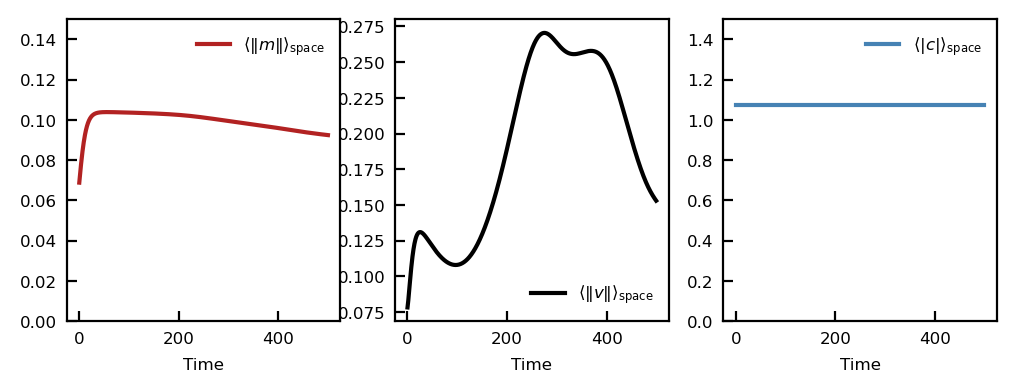

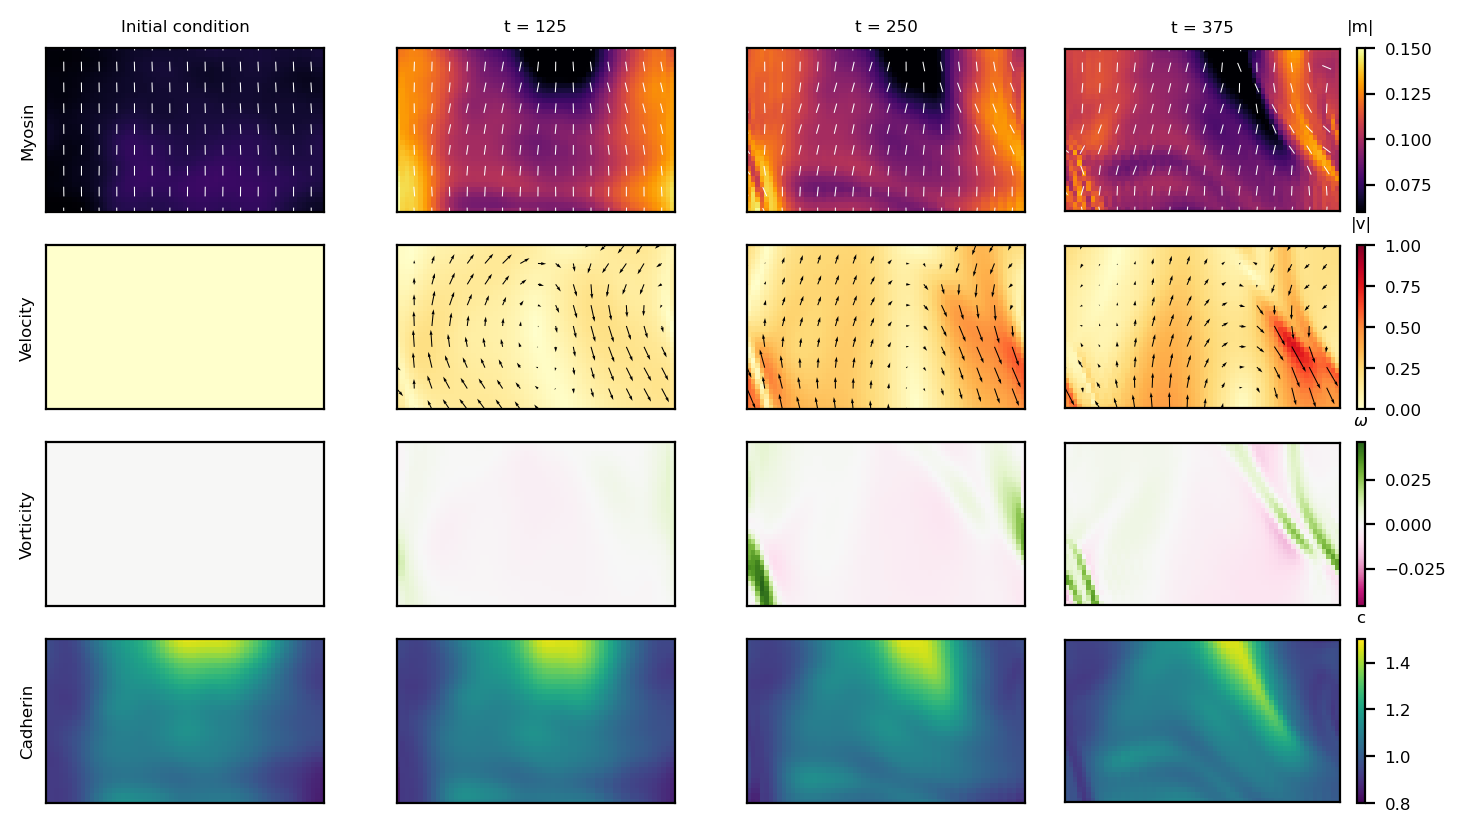

In [163]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 6

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def plot_all(h5f, slc=slice(None, None), dt=10, 
             mmin=0.06, mmax=0.15, 
             vmin=0, vmax=3, 
             cmin=0.8, cmax=1.5, 
             skip=4, half=True):
    #Collect data
    print(h5f)
    mij = h5f['tasks/m'][slc]
    vi  = h5f['tasks/v'][slc]
    c   = h5f['tasks/c'][slc]
    t0  = h5f['scales/sim_time'][slc]
  
    fig1, ax = plt.subplots(1, 3, dpi=200, figsize=(6, 2))
    ax[0].plot(t0, np.mean(np.linalg.norm(mij, axis=(1, 2)), axis=(1, 2)), 
                   color='firebrick', label=r"$\langle|\!|m|\!|\rangle_{{\rm space}}$")    
    ax[1].plot(t0[1:], np.mean(np.linalg.norm(vi[1:], axis=(1)), axis=(1, 2)),
                   color='black', label=r"$\langle|\!|v|\!|\rangle_{{\rm space}}$")
    ax[2].plot(t0, np.mean(c, axis=(1, 2)),
                   color='steelblue', label=r"$\langle|c|\rangle_{{\rm space}}$")
    for a in ax:
        a.set_xlabel('Time')
        a.tick_params(which='both', direction='in')
        a.legend(framealpha=False)
    ax[0].set_ylim([0, mmax])
    ax[2].set_ylim([0, 1.5])
        
    mij = mij[::dt]
    vi  = vi[::dt]
    c   = c[::dt]
    t0  = t0[::dt]
    
    x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
    y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
    w = mij.shape[0] * 2 + 1
    fig2, ax = plt.subplots(4, mij.shape[0], dpi=200, figsize=(w, 5.) if half else (w, 10))
    
    wi = np.gradient(vi[:, 1], x, axis=-2) - np.gradient(vi[:, 0], y, axis=-1)
    wmax = max(abs(np.min(wi)), np.max(wi))
        
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    for i, (mi, v, w, ci) in enumerate(zip(mij, vi, wi, c)):
        m, n = get_director_magnitude(mi)
        ax[0, i].set_title(f't = {t0[i]:g}')
        pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=mmin, vmax=mmax)
        ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T, **twargs)
        
        pcV = ax[1, i].pcolormesh(x, y, np.linalg.norm(v, axis=0).T, vmin=vmin, vmax=vmax, cmap='YlOrRd')
        ax[1, i].quiver(X, Y, v[0, ::skip, ::skip].T, v[1, ::skip, ::skip].T, color="black")
        pcW = ax[2, i].pcolormesh(x, y, w.T, cmap='PiYG', vmin=-wmax, vmax=wmax)
        
        pcC = ax[3, i].pcolormesh(x, y, ci.T, vmin=cmin, vmax=cmax, cmap='viridis')
    
    plt.colorbar(pcM, ax=ax[0, i]).ax.set_title("|m|")    
    plt.colorbar(pcV, ax=ax[1, i]).ax.set_title("|v|")
    plt.colorbar(pcW, ax=ax[2, i]).ax.set_title('$\\omega$')
    plt.colorbar(pcC, ax=ax[3, i]).ax.set_title('c')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')
        if half:
            a.set_ylim([0, a.get_ylim()[1]/2])
    ax[0, 0].set_title('Initial condition')
    
    ax[0, 0].set_ylabel('Myosin')
    ax[1, 0].set_ylabel('Velocity')
    ax[2, 0].set_ylabel('Vorticity')
    ax[3, 0].set_ylabel('Cadherin')
        
    fig2.subplots_adjust(wspace=0.02)
    
    return fig1, fig2
    
name = 'Cadherin_s4'
folder = name.split('_')[0]

slc = slice(0, None)
dt = 250

with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    fig1, fig2 = plot_all(h5f, slc, dt, vmax=1, half=True)
    #fig1.savefig(f'dedalus_runs/{folder}/{name}_trajectory.png', bbox_inches='tight')
    #fig2.savefig(f'dedalus_runs/{folder}/{name}_images.png', bbox_inches='tight')

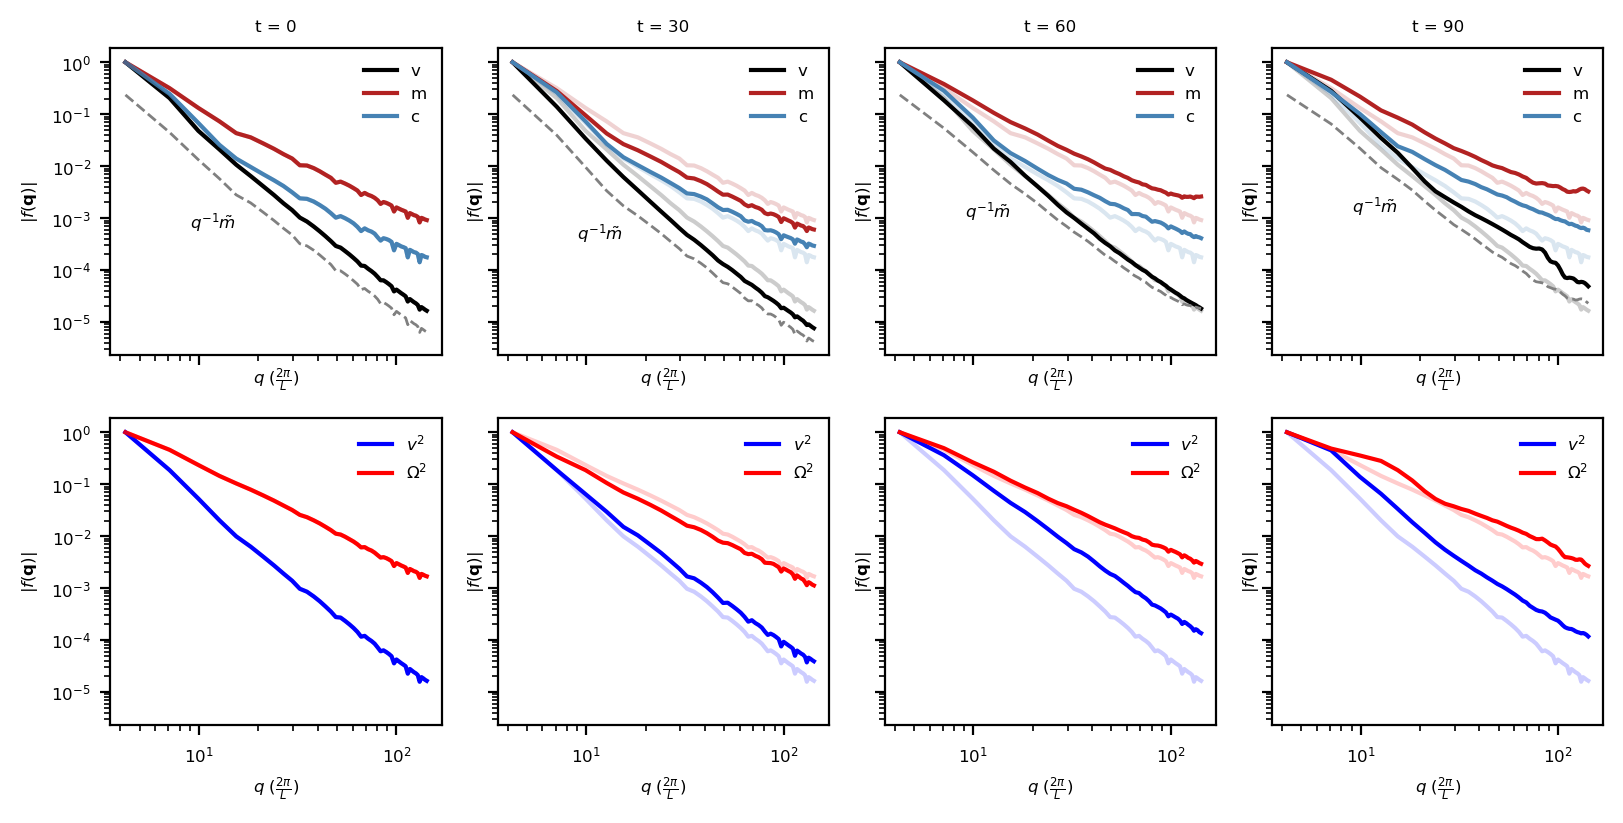

In [4]:
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 6

def get_director_magnitude(mij):
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]
    return m, n

def radial_average(arr, num_bins=100):
    nAP, nDV = arr.shape
    center = (nAP // 2, nDV // 2)

    x, y = np.meshgrid(np.arange(nAP), np.arange(nDV), indexing='xy')
    distances = np.hypot(x - center[1], y - center[0])

    sorted_distances = np.sort(distances.ravel())
    sorted_values = arr.ravel()[np.argsort(distances.ravel())]

    bins = np.linspace(0, sorted_distances.max(), num_bins+1)
    bin_indices = np.digitize(sorted_distances, bins)

    radial_avg = np.bincount(bin_indices, weights=sorted_values) / np.bincount(bin_indices)
    
    trunc = bins < nAP / (2 * 1.414)
    return radial_avg[1:][trunc][1:]

def plot_spectra(h5f, slc=slice(None, None, None), 
             exps=-2.5, 
             mmin=0.06, mmax=0.15, 
             vmin=0, vmax=1, 
             cmin=0.8, cmax=1.5, 
             skip=4):
    #Collect data
    mij = h5f['tasks/m'][slc]
    vi  = h5f['tasks/v'][slc][()]
    vi[0] = h5f['tasks/v'][1][()]
    c   = h5f['tasks/c'][slc]
    t0  = h5f['scales/sim_time'][slc]
    
    x = np.linspace(0, h5f['params/Lx'], mij.shape[-2])
    y = np.linspace(0, h5f['params/Ly'], mij.shape[-1])  
    
    qx = np.fft.fftshift(np.fft.fftfreq(len(x), d=x[1]-x[0])) * np.ptp(x)
    qy = np.fft.fftshift(np.fft.fftfreq(len(y), d=y[1]-y[0])) * np.ptp(y)
    q = np.linalg.norm(np.meshgrid(qx, qy, indexing='xy'), axis=0)
    q = radial_average(q)
    
    w = mij.shape[0] * 2 + 1
    fig1, ax1 = plt.subplots(2, mij.shape[0], dpi=200, figsize=(2*mij.shape[0], 4), 
                             constrained_layout=True, sharex=True, sharey=True)
    
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    twargs = dict(pivot='middle', color='white', headwidth=0, headlength=0, headaxislength=0)
    
    for i, (mi, v, ci) in enumerate(zip(mij, vi, c)):
        mq = np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(mi), axes=(-2, -1)))**2)
        vq = np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(v), axes=(-2, -1)))**2)
        cq = np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(ci), axes=(-2, -1)))**2)
        trmq = radial_average(mq[0, 0] + mq[1, 1])
        manq = radial_average(mq[0, 1])
        velq = radial_average(vq[0])
        cadq = radial_average(cq)
        
        kE = np.sum(v**2, axis=0)
        kEq = np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(kE), axes=(-2, -1)))**2)
        kEq = radial_average(kEq)
        
        vort = np.gradient(v[1], axis=0) - np.gradient(v[0], axis=1)
        vE = vort**2
        vEq = np.sqrt(np.abs(np.fft.fftshift(np.fft.fft2(vE), axes=(-2, -1)))**2)
        vEq = radial_average(vEq)
        
        ax1[0, i].plot(q, velq / velq[0], color='black', label='v')
        ax1[0, i].plot(q, trmq / trmq[0], color='firebrick', label='m')
        ax1[0, i].plot(q, cadq / cadq[0], color='steelblue', label='c')
        
        ax1[1, i].plot(q, kEq / kEq[0], color='blue', label='$v^2$')
        ax1[1, i].plot(q, vEq / vEq[0], color='red', label='$\\Omega^2$')

        if i == 0:
            for j in range(ax1.shape[1]):
                ax1[0, j].plot(q, velq / velq[0], color='black', alpha=0.2)
                ax1[0, j].plot(q, trmq / trmq[0], color='firebrick', alpha=0.2)
                ax1[0, j].plot(q, cadq / cadq[0], color='steelblue', alpha=0.2)
                ax1[1, j].plot(q, kEq / kEq[0], color='blue', alpha=0.2)
                ax1[1, j].plot(q, vEq / vEq[0], color='red', alpha=0.2)
        for j in range(ax1.shape[0]):
            ax1[j, i].set_yscale('log')
            ax1[j, i].set_xscale('log')
            ax1[j, i].set_xlabel(r'$q\ (\frac{2\pi}{L})$')
            ax1[j, i].set_ylabel(r'$|f(\mathbf{q})|$')
            ax1[j, i].legend(framealpha=0)
        
        ax1[0, i].set_title(f't = {t0[i]:g}')
        if exps is not None:
            if isinstance(exps, list):
                exp = exps[i]
            else:
                exp = exps
            qe1 = np.power(q, exp)
            qe2 = np.power(q, exp-1)

            qe1 = 3e0 * (qe1 / qe1[0])
            qe2 = 2e-1 * (qe2 / qe2[0])
            ax1[0, i].plot(q, qe1, color='grey', linestyle='--', linewidth=1)
            ax1[0, i].plot(q, qe2, color='grey', linestyle='--', linewidth=1)
            ax1[0, i].text(q[4], qe1[4] * 3e0, r'$\sim q^{%g}$' % (exp),
                           va='bottom', ha='left')
            ax1[0, i].text(q[4], qe2[4] * 1e-1, r'$\sim q^{%g}$' % (exp-1),
                           va='top', ha='right')
        else:
            qe1 = trmq / trmq[0]
            qe1 = qe1 / q
            ax1[0, i].plot(q, qe1, color='grey', linestyle='--', linewidth=1)
            ax1[0, i].text(q[4], qe1[4] * 5e-1, r'$q^{-1} \tilde{m}$',
                           va='top', ha='right')

name = 'Cadherin_s7'
slc = [0, 60, 120, 180]
exps = [-2, -2.5, -2, -1.5]
exps=None

folder = name.split('_')[0]
with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    plot_spectra(h5f, slc, exps=exps, vmax=1)

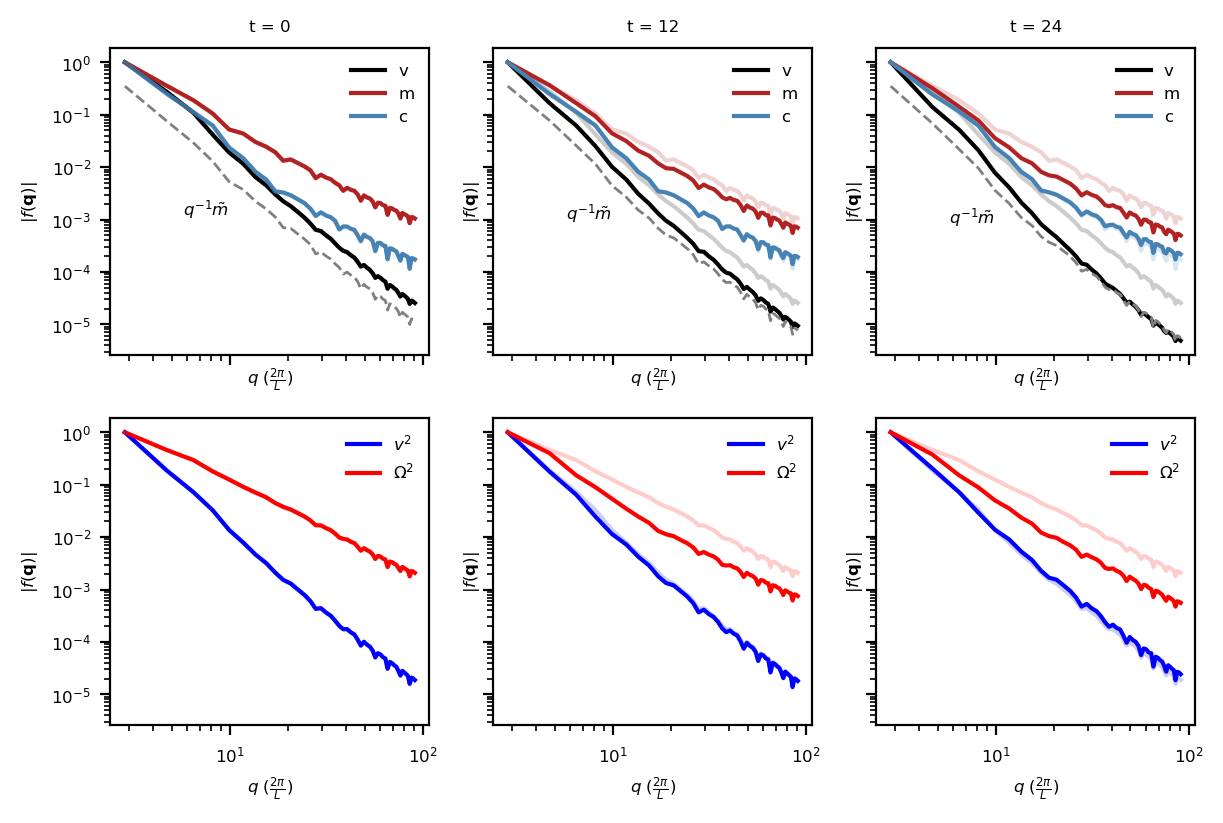

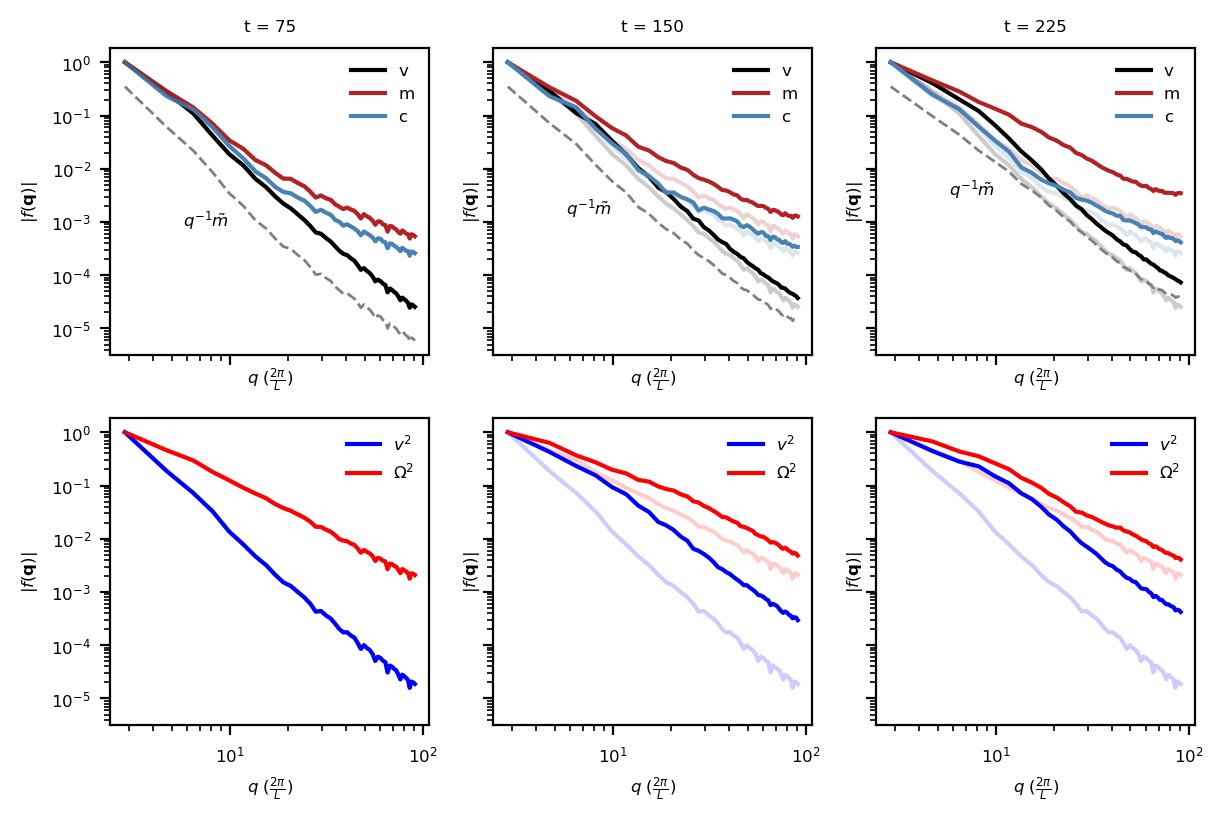

In [6]:
name = 'Cadherin_s8'
slc  = [0, 24, 48]
exps = [-1.8, -2.2, -2.5]
exps = None

folder = name.split('_')[0]
with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    plot_spectra(h5f, slc, exps=exps, vmax=1)
    
slc  = [150, 300, 450]
exps = None

folder = name.split('_')[0]
with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    plot_spectra(h5f, slc, exps=exps, vmax=1)

<HDF5 file "Cadherin_s4.h5" (mode r)>


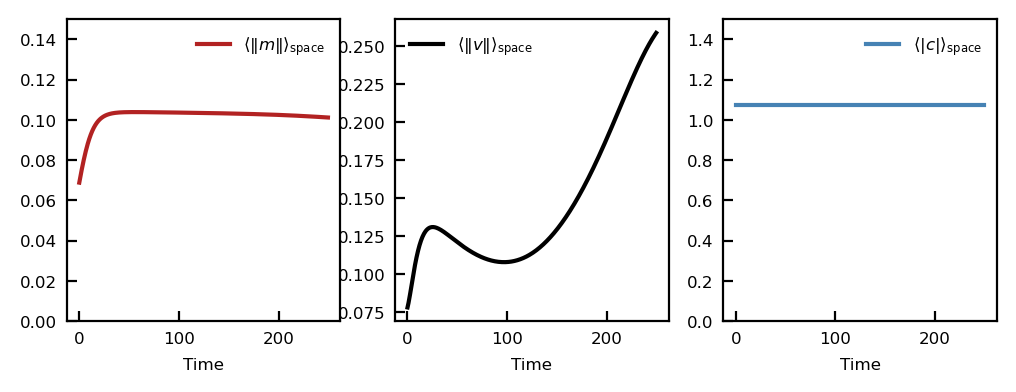

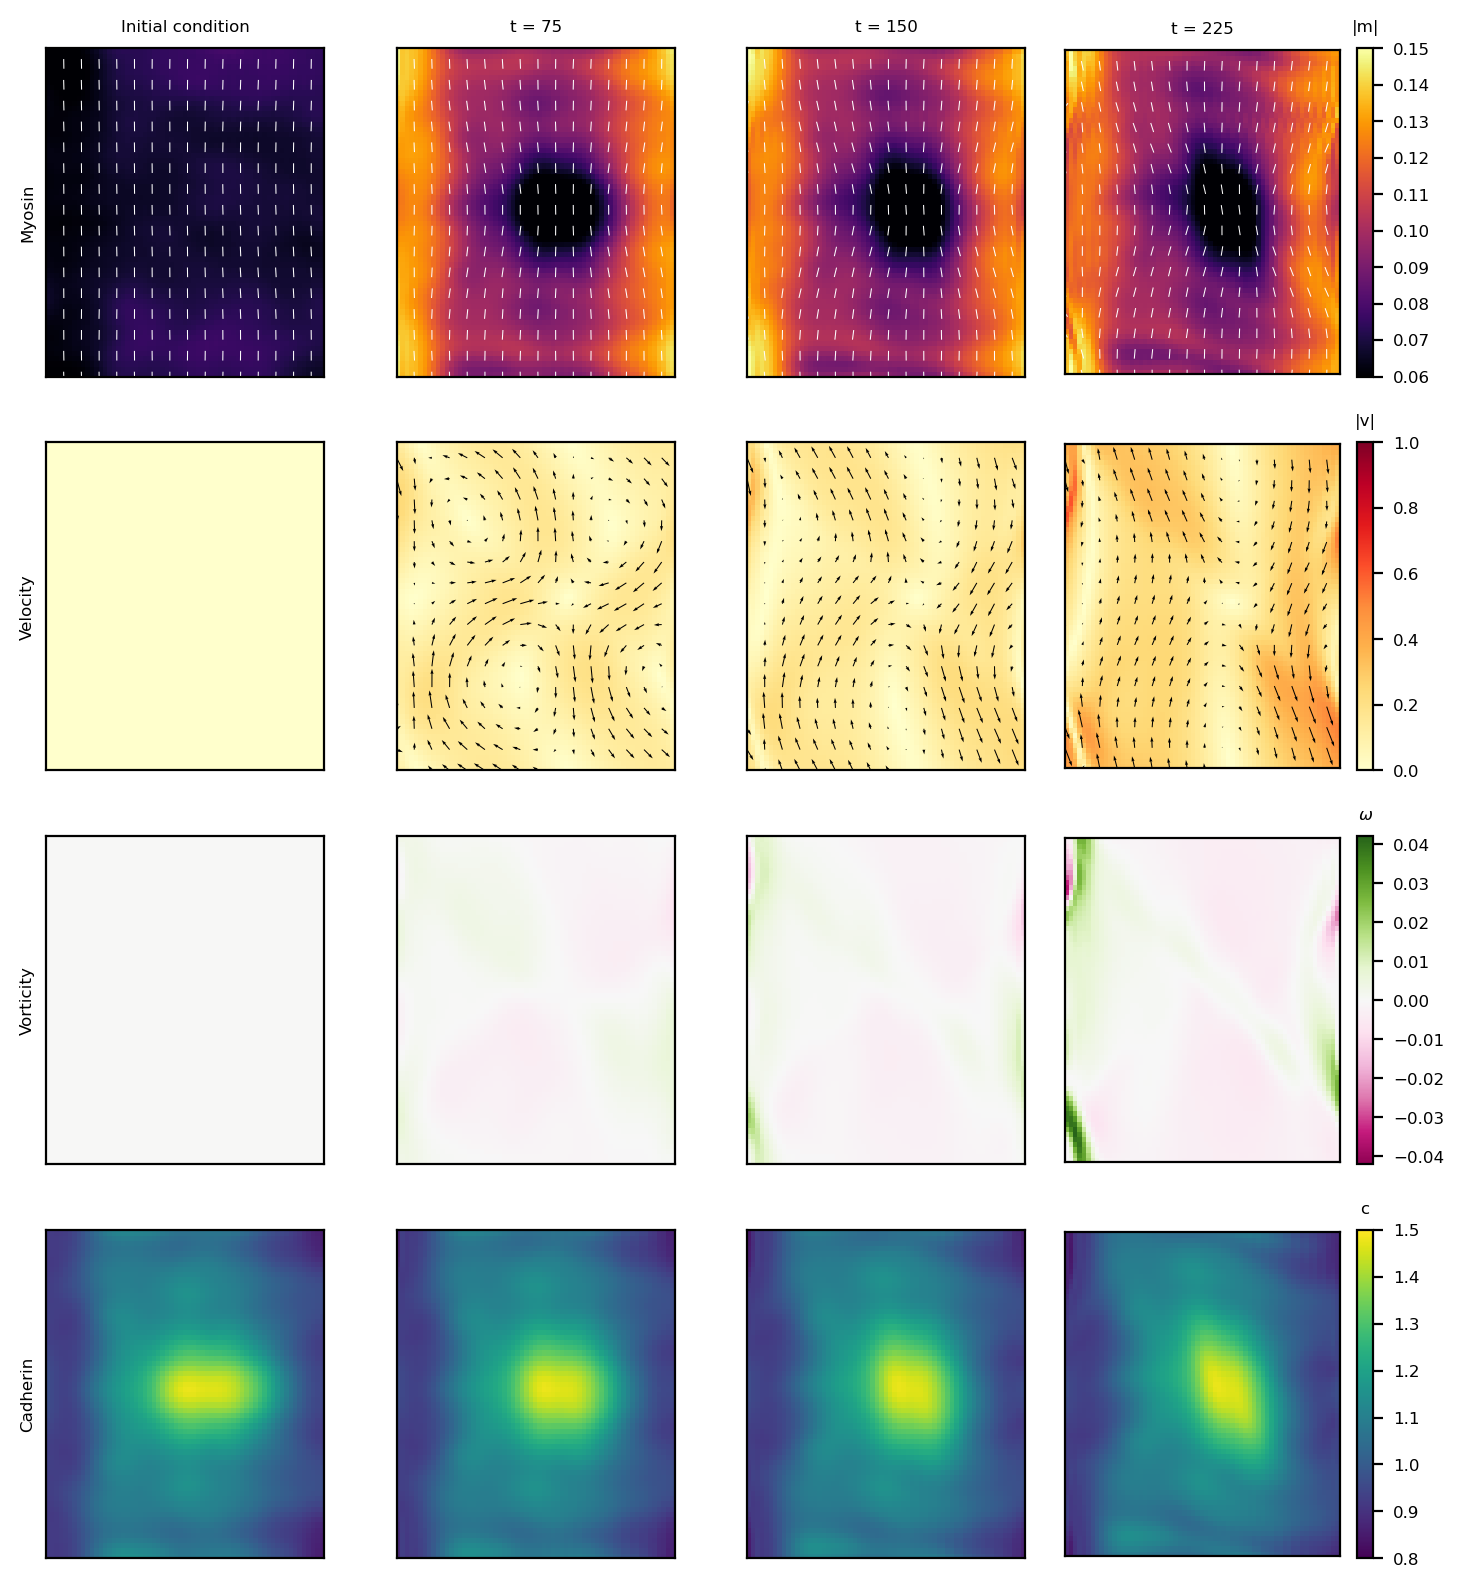

In [216]:
name = 'Cadherin_s4'
slc1 = slice(None, 500)
dt = 150

folder = name.split('_')[0]
with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    plot_all(h5f, slc1, dt, vmax=1, half=False, skip=4)

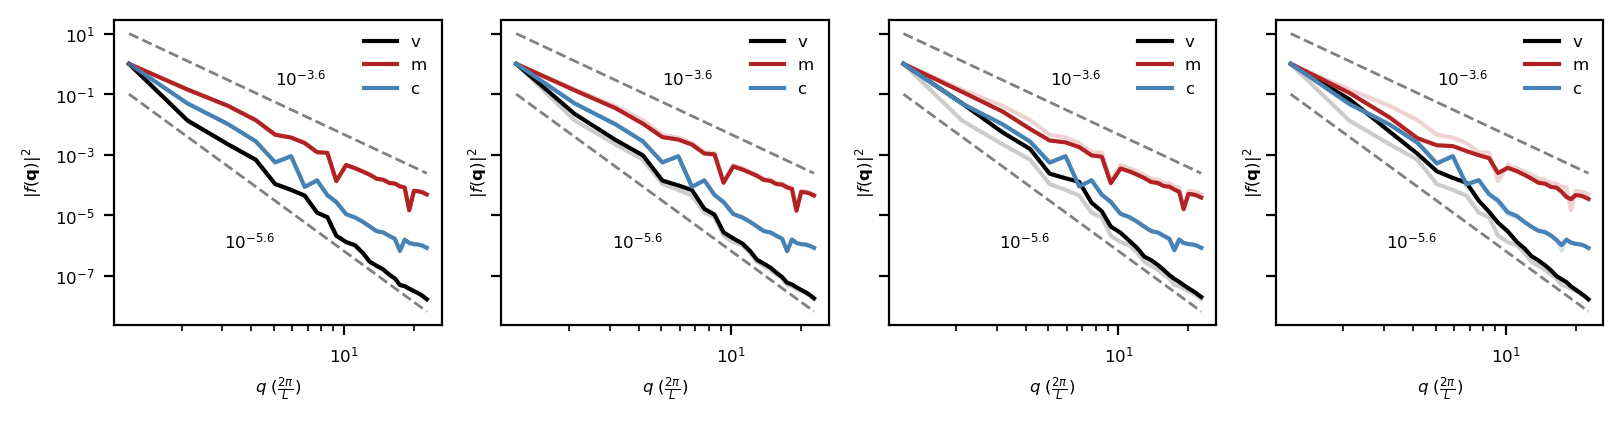

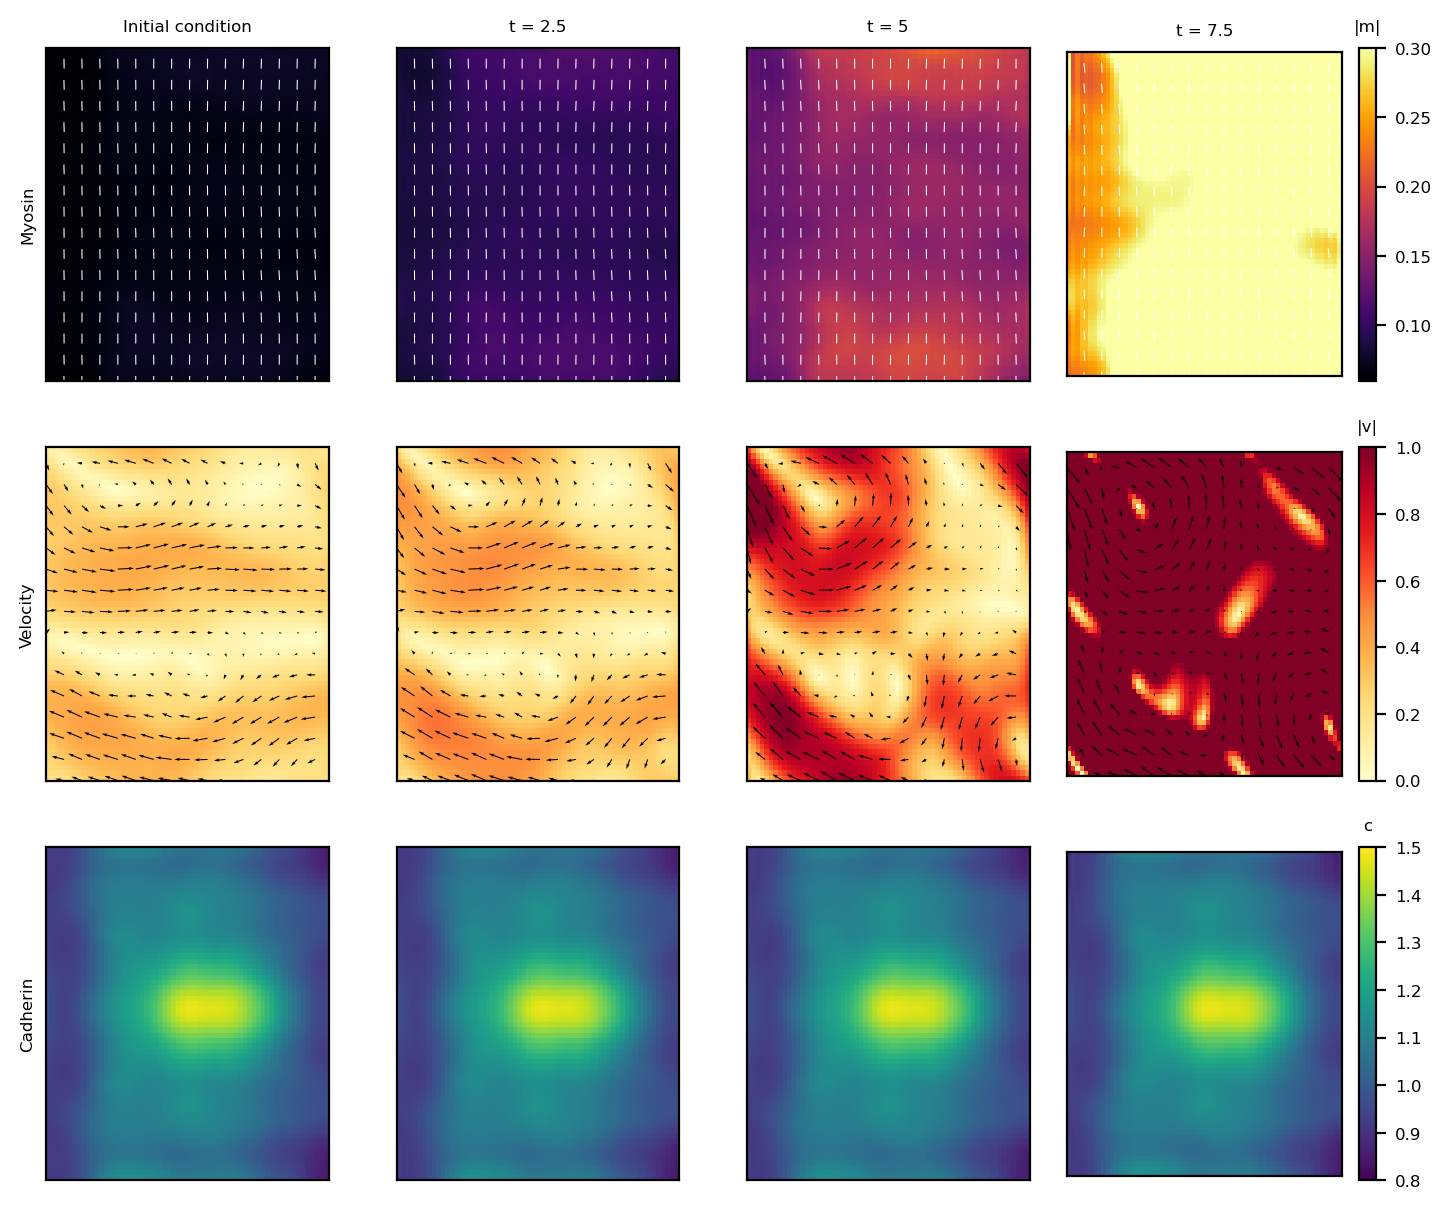

In [150]:
name = 'Quadratic_s3'
folder = name.split('_')[0]

slc = slice(0, 20, 5)
exps = [-1.8, -1.8, -1.8, -1.8]

with h5py.File(f'dedalus_runs/{folder}/{name}.h5', 'r') as h5f:
    plot_spectra(h5f, slc, exps=exps, vmax=1, mmax=0.3)